# DeepLabeler

In this notebook we will train the DeepLabeler architecture.

In [1]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.nn as nn
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
tqdm.pandas()
from functools import partial
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
from datetime import datetime

start_time = datetime.now()

torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load in data and pretrained models

In [2]:
data = pd.read_parquet('prepared-data.pq')
data.head()

,SUBJECT_ID,HADM_ID,TEXT,toks,ICD9_CODE
0,3,145834.0,sex m service medicine chief complaint admitt...,"[sex, m, service, medicine, chief, complaint, ...","[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
1,4,185777.0,sex f service chief complaint shortness of br...,"[sex, f, service, chief, complaint, shortness,...","[042, 1363, 7994, 2763, 7907, 5715, 04111, V090]"
2,6,107064.0,sex f service admission diagnosis end stage r...,"[sex, f, service, admission, diagnosis, end, s...","[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."
3,9,150750.0,sex m service neurology chief complaint weakn...,"[sex, m, service, neurology, chief, complaint,...","[431, 5070, 4280, 5849, 2765, 4019]"
4,10,184167.0,sex f service history of present illness baby...,"[sex, f, service, history, of, present, illnes...","[V3000, 7742, 76525, 76515, V290]"


In [3]:
docs = pd.read_parquet('prepared-doc2vec.pq')
docs.head()

,vec.0,vec.1,vec.2,vec.3,vec.4,vec.5,vec.6,vec.7,vec.8,vec.9,...,vec.120,vec.121,vec.122,vec.123,vec.124,vec.125,vec.126,vec.127,SUBJECT_ID,HADM_ID
0,-1.168114,-0.364408,-0.351587,0.042022,-0.216914,-1.940896,0.732966,0.029827,-1.218427,1.241066,...,0.717602,0.417174,1.228172,2.783473,-0.348849,-0.746716,-0.254826,-0.162575,3,145834.0
1,-1.172263,1.296322,0.629791,2.072700,1.218928,-0.833741,0.648946,-1.671474,0.172852,1.269101,...,1.570506,-0.722183,-0.057752,1.903284,2.839895,0.018530,0.393880,1.606591,4,185777.0
2,-1.003505,0.817260,0.758062,0.308259,1.973406,-0.495774,0.429993,-0.705302,0.584977,-0.025737,...,-0.982737,1.033692,1.223478,1.897892,2.041448,-2.154160,1.752321,-0.315013,6,107064.0
3,-2.658166,1.205859,0.588380,-0.868180,0.052036,-0.845896,-0.286720,0.319456,-1.260307,1.001276,...,1.185009,-0.650903,0.230766,1.178955,-1.222234,-0.486649,-0.897554,0.288846,9,150750.0
4,-0.528551,1.135079,1.261992,0.542736,1.472284,-0.440664,0.915686,-0.205491,-0.306012,1.124715,...,0.184678,-0.164261,0.018767,1.694578,0.353929,-1.015501,-0.642076,-0.294704,10,184167.0


Add Doc2Vec vectors

In [4]:
docs['doc'] = docs[[col for col in docs.columns if col.startswith('vec')]].apply(lambda x: np.array(x), axis=1)
data = data.merge(docs[['HADM_ID', 'SUBJECT_ID', 'doc']], on=['HADM_ID', 'SUBJECT_ID'])
data.head()

,SUBJECT_ID,HADM_ID,TEXT,toks,ICD9_CODE,doc
0,3,145834.0,sex m service medicine chief complaint admitt...,"[sex, m, service, medicine, chief, complaint, ...","[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...","[-1.1681137, -0.3644082, -0.35158673, 0.042021..."
1,4,185777.0,sex f service chief complaint shortness of br...,"[sex, f, service, chief, complaint, shortness,...","[042, 1363, 7994, 2763, 7907, 5715, 04111, V090]","[-1.172263, 1.2963222, 0.62979126, 2.0726995, ..."
2,6,107064.0,sex f service admission diagnosis end stage r...,"[sex, f, service, admission, diagnosis, end, s...","[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1...","[-1.0035045, 0.81726044, 0.75806165, 0.3082590..."
3,9,150750.0,sex m service neurology chief complaint weakn...,"[sex, m, service, neurology, chief, complaint,...","[431, 5070, 4280, 5849, 2765, 4019]","[-2.6581664, 1.2058591, 0.5883799, -0.8681802,..."
4,10,184167.0,sex f service history of present illness baby...,"[sex, f, service, history, of, present, illnes...","[V3000, 7742, 76525, 76515, V290]","[-0.5285514, 1.1350787, 1.2619925, 0.5427365, ..."


In [5]:
data['toks'].apply(lambda x: len(x)).min()

28

Load in word2vec model

In [6]:
w2v = Word2Vec.load('word2vec.model')

Loading in these vectors as tensors before the collate function saved a lot of time. 

In [7]:
vecs = {word: torch.tensor(vec, device=device, dtype=torch.float) for word, vec in zip(w2v.wv.index_to_key, w2v.wv.vectors)}

Define the dataset

In [8]:
class CustomDataset(Dataset):
    
    def __init__(self, data):
        self.mlb = MultiLabelBinarizer()
        self.y = torch.tensor(np.vstack(self.mlb.fit_transform(data['ICD9_CODE'].to_list())), dtype=torch.float, device=device)
        self.W = data['toks'].to_list()
        self.D = torch.tensor(data['doc'], device=device)
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return self.W[index], self.D[index], self.y[index]
    
dataset = CustomDataset(data)

/tmp/ipykernel_15424/1800646028.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.D = torch.tensor(data['doc'], device=device)


In [9]:
assert next(iter(dataset))[-1].shape[0] == dataset.mlb.classes_.shape[0]

Define the collate function

In [10]:
def collate(w2v, max_token_length, data):
    """
    Get word vectors and document vectors for each batch

    Arguments:
        data: batch data from generator
        w2v: Pre-trained Word2Vec model
        max_token_length: Maximum length of sequences of tokens to use

    Returns:
        word_matrix (batch, max_token_length, w2v embedding size), document_vector (batch_size, d2v embedding size), y (batch_size, max_icd9_length)
    """
    W, D, y = zip(*data)
    D = torch.vstack(D)
    y = torch.vstack(y)

    word_matrix = torch.zeros((len(W), max_token_length, w2v.vector_size), device=device)
    # D = torch.vstack(D)
    for i, sentence in enumerate(W):
        l = []
        j = 0
        for word in sentence:
            if j < 700:
                if vecs.get(word) is not None:
                    l.append(vecs[word])
                    j += 1
            else:
                break
        word_matrix[i, :len(l)] = torch.vstack(l)

    return word_matrix, D, y

In [11]:
# I used this cell to test my preprocessing script
# I found that minimizing copying tensors over (even in gpu) saves time

# # %%timeit
# W, D, y = dataset[:10]

# word_matrix = torch.zeros((len(W), max_token_length, w2v.vector_size), device=device)
# # D = torch.vstack(D)
# for i, sentence in enumerate(W):
#     j = 0
#     l = []
#     for word in sentence:
#         if j < 700:
#             if vecs.get(word) is not None:
#                 # word_matrix[i, j] = vecs[word]
#                 l.append(vecs[word])
#                 j += 1
#         else:
#             break
#     word_matrix[i, :len(l)] = torch.vstack(l)

Create train/test split and create data loaders

In [12]:
split = int(len(dataset)*0.8)
lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

# Hyperparameters
batch_size = 64
max_token_length = 700
embedding_size = 100
output_size = len(dataset.mlb.classes_)

collate_fn = partial(collate, w2v, max_token_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)

In [13]:
# I used this cell for testing the time to loop, it eventually took 30s to loop through the whole dataset
# for W, D, y in tqdm(train_loader):
#     pass

Calcuate the convolution kernel size

In [14]:
def conv_output_volume(W, F, S, P):
    
    """
    TODO: Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    Note the output should a integer. 
    """
    
    # your code here
#     raise NotImplementedError
    return (W - F + 2*P ) // S + 1

## Define the Model

In [36]:
class DeepLabeler(nn.Module):
    def __init__(self, embedding_size, max_token_length, output_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.max_token_length = max_token_length
        self.output_size = output_size

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3))
        self.cnn2 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4,4))
        self.cnn3 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,5))
        # self.pool1 = nn.MaxPool2d((conv_output_volume(self.max_token_length, 3, 1, 0), conv_output_volume(self.embedding_size, 3, 1, 0)))
        # self.pool2 = nn.MaxPool2d((conv_output_volume(self.max_token_length, 4, 1, 0), conv_output_volume(self.embedding_size, 4, 1, 0)))
        # self.pool3 = nn.MaxPool2d((conv_output_volume(self.max_token_length, 5, 1, 0), conv_output_volume(self.embedding_size, 5, 1, 0)))
        self.dropout = nn.Dropout(p=0.75)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(256, self.output_size)


    def forward(self, W: torch.Tensor, D: torch.Tensor):
        W = W.unsqueeze(dim=1)
        out1 = self.dropout(torch.relu(self.cnn1(W)))
        out2 = self.dropout(torch.relu(self.cnn2(W)))
        out3 = self.dropout(torch.relu(self.cnn3(W)))

        V = torch.concat((out1.max(), out2.max(), out3.max(), self.dropout(torch.relu(self.fc1(D)))), dim=1)
        
        return torch.sigmoid(self.fc2(V))

model = DeepLabeler(embedding_size, max_token_length, output_size)
model

DeepLabeler(
  (cnn1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
  (cnn3): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.75, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=256, out_features=1292, bias=True)
)

In [37]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

343692

## Setup Loss and Optimizer

In [38]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion.cuda()
model.cuda()


DeepLabeler(
  (cnn1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
  (cnn3): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.75, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=256, out_features=1292, bias=True)
)

## Train Model

In [39]:
n_epoch = 5
epoch_loss = []

for epoch in range(n_epoch):
    curr_epoch_loss = []
    for W, D, y in tqdm(train_loader):
        """
        TODO: Within the loop, do the normal training procedures:
                pass the input through the model
                pass the output through loss_func to compute the loss (name the variable as *loss*)
                zero out currently accumulated gradient, use loss.basckward to backprop the gradients, then call optimizer.step
        """
        # clear gradients
        optimizer.zero_grad()
        
        # with torch.cuda.amp.autocast():
                # forward pass
        y_hat = model(W, D)

        # calucate loss
        loss = criterion(y_hat, y)

        # backward pass
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        curr_epoch_loss.append(loss.cpu().data.numpy())
    print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    epoch_loss.append(np.mean(curr_epoch_loss))

100%|██████████| 658/658 [01:47<00:00,  6.10it/s]


Epoch 0: curr_epoch_loss=42.92426300048828


100%|██████████| 658/658 [01:24<00:00,  7.83it/s]


Epoch 1: curr_epoch_loss=42.13479995727539


100%|██████████| 658/658 [01:24<00:00,  7.79it/s]


Epoch 2: curr_epoch_loss=42.03044891357422


 79%|███████▉  | 519/658 [02:00<00:31,  4.46it/s]

In [ ]:
torch.save(model.state_dict(), 'model-state.pt')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


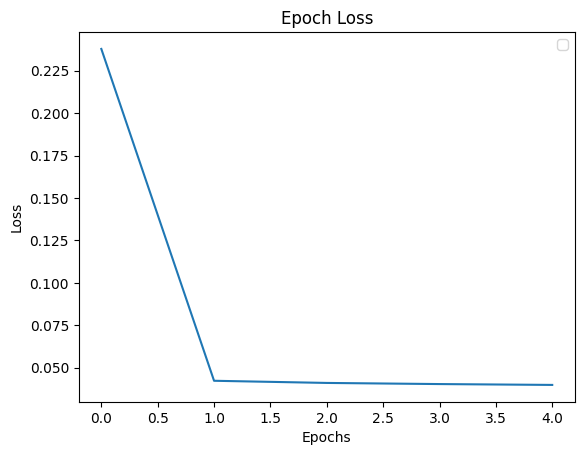

In [ ]:
plt.figure()
plt.title("Epoch Loss")
plt.plot(epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt.text()
# plt.savefig('deeplabeler-fscore.png')
plt.show()

In [ ]:
end = datetime.now()
total_time = end - start_time
total_time

datetime.timedelta(seconds=1050, microseconds=410036)

# Evaluate Model

In [ ]:
model2 = DeepLabeler(embedding_size, max_token_length, output_size)
model2.cuda()
model2.load_state_dict(torch.load('model-state.pt'))

<All keys matched successfully>

In [ ]:
Y = None
Y_hat = None
model2.eval()
with torch.no_grad():
    y_hat_list = []
    y_list = []
    for W, D, y in tqdm(val_loader):
        y_hat = model2(W, D).detach().cpu().numpy()
        y_list.append(y.detach().cpu().numpy())
        y_hat_list.append(y_hat)
    Y = np.vstack(y_list)
    Y_hat = np.vstack(y_hat_list)

100%|██████████| 165/165 [00:08<00:00, 18.69it/s]


## Evaluate at different thresholds

In [ ]:
thresholds = np.arange(0, 1, 0.1)
data = []
for threshold in tqdm(thresholds):
    y_pred_cls = (Y_hat > threshold) * 1
    precision, recall, fscore, support = precision_recall_fscore_support(Y, y_pred_cls, average='micro')
    data.append((threshold, precision, recall, fscore, support))

 80%|████████  | 8/10 [00:08<00:01,  1.07it/s]/home/ryan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████ | 9/10 [00:08<00:00,  1.08it/s]/home/ryan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


## Store Results and Create Plots

In [ ]:
df = pd.DataFrame(data, columns=['threshold', 'precision', 'recall', 'fscore', 'support'])
df.head()

,threshold,precision,recall,fscore,support
0,0.0,0.008417,1.000000,0.016694,None
1,0.1,0.235841,0.309217,0.267590,None
2,0.2,0.387975,0.160506,0.227072,None
3,0.3,0.497462,0.102755,0.170327,None
4,0.4,0.595373,0.064304,0.116071,None


In [ ]:
df.iloc[df['fscore'].argmax()]

threshold         0.1
precision    0.235841
recall       0.309217
fscore        0.26759
support          None
Name: 1, dtype: object

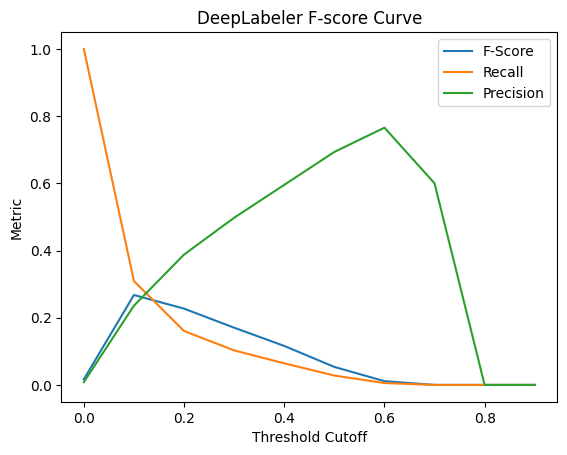

In [ ]:
plt.figure()
plt.title("DeepLabeler F-score Curve")
plt.plot(df['threshold'], df['fscore'], label='F-Score')
plt.plot(df['threshold'], df['recall'], label='Recall')
plt.plot(df['threshold'], df['precision'], label='Precision')
plt.xlabel('Threshold Cutoff')
plt.ylabel('Metric')
plt.legend(loc='upper right')
# plt.text()
plt.savefig('deeplabeler-fscore.png')
plt.show()

In [ ]:
df.to_csv('deeplabeler-scores.csv')

In [ ]:
# I used this cell for debugging
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

In [ ]:
end = datetime.now()
total_time = end - start_time
total_time